In [1]:
import numpy as np
import math
from numba import cuda, float32

In [2]:
@cuda.jit(device=True)
def normalize_vector(input_array):
    norm = float32(0.0)
    for i in range(len(input_array)):
        norm += input_array[i] ** 2
    norm = math.sqrt(norm)
    if norm > 0:
        for i in range(len(input_array)):
            input_array[i] /= norm

In [3]:
@cuda.jit(device=True)
def dot_product(a, b):
    result = 0.0
    for i in range(len(a)):
        result += a[i] * b[i]
    return result

In [4]:
@cuda.jit(device=True)
def phong_lighting(color, hit_point, normal, light_pos, view_dir, light_color, ambient_color, ambient_reflection, diffuse_reflection, specular_reflection, shininess):
    """
    Compute the Phong lighting model.

    Parameters:
    - hit_point: The point of intersection.
    - normal: Normal at the hit point.
    - light_pos: Position of the light source.
    - view_dir: Direction towards the camera.
    - ambient_color, diffuse_reflection, specular_reflection: RGB arrays for ambient, diffuse, and specular components.
    - shininess: Specular shininess coefficient.

    Returns:
    - final_color: Computed color based on Phong model.
    """
    # Light position
    light_pos = cuda.local.array(3, dtype=float32)
    for i in range(3):
      light_pos[i] = light_pos[i]

    # Diffuse
    light_dir = cuda.local.array(3, dtype=float32)

    ambient = cuda.local.array(3, dtype=float32)
    for i in range(3):
        ambient[i] = ambient_reflection[i] * ambient_color[0][i]

    for i in range(3):
        light_dir[i] = light_pos[i] - hit_point[i]
    normalize_vector(light_dir)
    diffuse_intensity = max(dot_product(normal, light_dir), 0.0)
    diffuse = cuda.local.array(3, dtype=float32)
    for i in range(3):
        diffuse[i] = diffuse_reflection[i] * light_color[0][i] * diffuse_intensity

    # Specular
    reflect_dir = cuda.local.array(3, dtype=float32)
    for i in range(3):
        reflect_dir[i] = 2.0 * dot_product(normal, light_dir) * normal[i] - light_dir[i]
    normalize_vector(reflect_dir)
    specular_intensity = pow(max(dot_product(view_dir, reflect_dir), 0.0), shininess)
    specular = cuda.local.array(3, dtype=float32)
    for i in range(3):
        specular[i] = specular_reflection[i] * light_color[0][i] * specular_intensity

    # Combine components
    for i in range(3):
        color[i] = ambient[i] + diffuse[i] + specular[i]
        #color[i] = min(max(color[i], 0.0), 1.0)  # Clamp to [0, 1]
    return color

In [5]:
@cuda.jit(device=True)
def ray_sphere_intersection(ray_origin, ray_direction, center, radius):
    oc = cuda.local.array(3, dtype=float32)
    for i in range(3):
        oc[i] = ray_origin[i] - center[i]

    a = dot_product(ray_direction, ray_direction)
    b = 2.0 * dot_product(oc, ray_direction)
    c = dot_product(oc, oc) - radius * radius
    discriminant = b * b - 4 * a * c

    if discriminant > 0.0:
        t = (-b - math.sqrt(discriminant)) / (2.0 * a)
        if t > 0.001:
            return t, True
    return float('inf'), False

In [6]:
@cuda.jit
def render(image, width, height, spheres, num_spheres, light_pos, light_color, ambient_color):
    x, y = cuda.grid(2)
    if x >= width or y >= height:
        return

    idx = y * width + x
    u = x / width
    v = y / height

    # Ray origin
    ray_origin = cuda.local.array(3, dtype=float32)
    ray_origin[0] = 0.0
    ray_origin[1] = 0.0
    ray_origin[2] = 0.0

    # Ray direction
    # --- The camera is the [-1, 1]x[-1, 1] box located at z = 0.
    ray_direction = cuda.local.array(3, dtype=float32)
    ray_direction[0] = 2.0 * u - 1.0
    ray_direction[1] = 2.0 * v - 1.0
    ray_direction[2] = -1.0
    normalize_vector(ray_direction)

    closest_t = float('inf')
    hit_sphere = -1
    hit_point = cuda.local.array(3, dtype=float32)
    normal = cuda.local.array(3, dtype=float32)

    for i in range(num_spheres):
        center          = spheres[i, :3]
        radius          = spheres[i, 3]
        t, hit = ray_sphere_intersection(ray_origin, ray_direction, center, radius)
        if hit and t < closest_t:
            closest_t = t
            hit_sphere = i
            for j in range(3):
                hit_point[j] = ray_origin[j] + t * ray_direction[j]
                normal[j] = (hit_point[j] - center[j]) / radius
            normalize_vector(normal)

    color = cuda.local.array(3, dtype=float32)
    if hit_sphere >= 0:
        view_dir              = cuda.local.array(3, dtype=float32)
        ambient_reflection    = spheres[hit_sphere, 4:7]
        diffuse_reflection    = spheres[hit_sphere, 7:10]
        specular_reflection   = spheres[hit_sphere, 10:13]
        shininess             = spheres[hit_sphere, 13]
        for j in range(3):
            view_dir[j] = -ray_direction[j]
        normalize_vector(view_dir)
        phong_lighting(color,
            hit_point, normal, light_pos, view_dir,
            light_color, ambient_color, ambient_reflection, diffuse_reflection, specular_reflection, shininess
        )
    else:
      for j in range(3):
        color[j] = 0.

    max_intensity = max(1.0, max(color[0], color[1], color[2]))
    for i in range(3):
        color[i] = color[i] / max_intensity

    image[idx, 0] = color[0]
    image[idx, 1] = color[1]
    image[idx, 2] = color[2]

In [7]:
# Light position
# --- The z coordinate of the light position should be positive as the light illuminates towards the negative z direction
h_light_pos        = np.array([[0.0, 0.0, 5.0]], dtype = np.float32)

h_ambient_color    = np.array([[1., 0., 0.]], dtype = np.float32)
h_light_color      = np.array([[0., 0.5, 0.5]], dtype = np.float32)

light_pos          = cuda.to_device(h_light_pos)
ambient_color      = cuda.to_device(h_ambient_color)
light_color        = cuda.to_device(h_light_color)

In [8]:
# Sphere properties: x, y, z, radius, ambient_r, ambient_g, ambient_b, diffuse_r, diffuse_g, diffuse_b, specular_r, specular_g, specular_b, shininess
spheres_data = np.array([
#    [0.0, 0.0, -1.0, 0.5, 0.2, 0.4, 0.3, 0.3, 0.5, 0.01, 0.2, 0.5, 0.9, 8.0],
#    [1.0, 0.0, -1.5, 0.5, 0.3, 0.1, 0.7, 0.6, 0., 0.0, 0.1, 0.3, 0.2, 20.0],
    [-0.65, 0.0, -1.5, 0.5, 0.3, 0.1, 0.3, 0.3, 0.5, 0.01, 0.8, 0.5, 0.9, 8.0],
    [ 0.65, 0.0, -1.5, 0.5, 0.3, 0.1, 0.3, 0.3, 0.5, 0.01, 0.8, 0.5, 0.9, 8.0],
], dtype=np.float32)

In [9]:
# Image dimensions
width, height = 800, 400
threads_per_block = (16, 16)
blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

In [10]:
# Allocate memory for the image
image = np.zeros((width * height, 3), dtype=np.float32)
image_gpu = cuda.to_device(image)
spheres_gpu = cuda.to_device(spheres_data)

In [11]:
# Launch the kernel
render[blocks_per_grid, threads_per_block](image_gpu, width, height, spheres_gpu, len(spheres_data), light_pos, light_color, ambient_color)

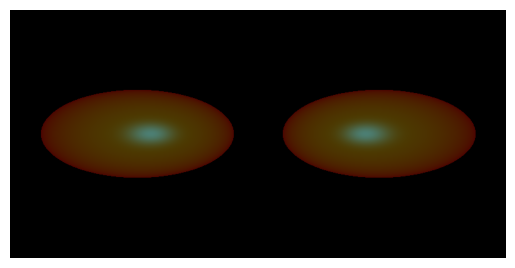

In [12]:
# Copy the result back to host
image_gpu.copy_to_host(image)

# Normalize dynamically if needed
max_val = np.max(image)
if max_val > 1.0:
    image /= max_val
image = (image * 255).astype(np.uint8)

# Reshape and save
image = image.reshape((height, width, 3))
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')
plt.show()
